# **Tutorial 8: Comparing Satellite Products With In Situ Data**

**Week 1, Day 3, Remote Sensing**

**Content creators:** Douglas Rao

**Content reviewers:** Katrina Dobson, Younkap Nina Duplex, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

In this tutorial, our primary focus will be on the 'Verification of Satellite Data'. Building on our previous modules where we explored various climate applications of satellite data, we will now delve into the critical task of assessing the quality and reliability of such data.

By the end of this tutorial, you will be able to understand the importance of verifying satellite data for accurate climate applications 

You will learn how to use observations from stations over land to evaluate satellite climate data. 

*  Learn how to access the gridded climate data derived from station observations from AWS.
*  Learn how to convert monthly total values to daily rate.
*  Learn how to correctly compare satellite and observation-based data for evalution.

# **Setup**

In [ ]:
# !pip install s3fs --quiet

# # Properly install cartopy in colab to avoid session crash
# !apt-get install libproj-dev proj-data proj-bin --quiet
# !apt-get install libgeos-dev --quiet
# !pip install cython --quiet
# !pip install cartopy --quiet

# !apt-get -qq install python-cartopy python3-cartopy  --quiet
# !pip uninstall -y shapely  --quiet
# !pip install shapely --no-binary shapely  --quiet

In [1]:
# imports
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pooch
import os
import boto3
import botocore

In [2]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [3]:
# @title Video 1: Video 1 Name
#Tech team will add code to format and display the video

# **Section 1: Evaluating Satellite Data with Observations**



Satellite data is frequently cross-verified against observations deemed reliable to evaluate its quality. Station-based observations and derived data are typically regarded as a reliable reference. When it comes to oceanic data, measurements taken by ships, buoys, drifters, or gliders are often used as a benchmark to assess the quality of satellite data.

In this tutorial, we will be using the nClimGrid dataset, a gridded climate dataset produced by NOAA. This dataset provides daily and monthly temperature and precipitation data, leveraging all available station observations. However, it's important to note that this dataset is exclusive to the United States. We have selected this dataset due to its public availability on AWS. You are encouraged to explore other station data for the evaluation of satellite data in your projects.

## **Section 1.1: Accesing nClimGrid - a station based gridded climate data**

The nClimGrid-monthly dataset is a gridded dataset derived from spatially interpolating data from the [Global Historical Climatology Network (GHCN)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily). The dataset includes monthly precipitation, monthly temperature average, monthly temperature maximum and monthly temperature minimum.  The dataset provides monthly values in a approximate 5x5 km lat/lon grid for the Continental United States. Data is available from 1895 to the present via NOAA NCEI or AWS. We will be accessing the data via AWS directly.


In [2]:
# Connect to the AWS S3 bucket for the nClimGrid Monthly Precipitation data

# Read in the monthly precipitation data from nClimGrid on AWS
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED)) # initialize aws s3 bucket client

file_nclimgrid = 'noaa-nclimgrid-monthly-pds/nclimgrid_prcp.nc'
ds = xr.open_dataset(pooch.retrieve('http://s3.amazonaws.com/'+file_nclimgrid,known_hash=None ))
ds

C:\ProgramData\Anaconda3\envs\climatematch_test\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'rasterio' loading failed:
DLL load failed while importing _version: The specified procedure could not be found.
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:  (time: 1540, lat: 596, lon: 1385)
Coordinates:
  * time     (time) datetime64[ns] 1895-01-01 1895-02-01 ... 2023-04-01
  * lat      (lat) float32 49.35 49.31 49.27 49.23 ... 24.69 24.65 24.6 24.56
  * lon      (lon) float32 -124.7 -124.6 -124.6 -124.6 ... -67.1 -67.06 -67.02
Data variables:
    prcp     (time, lat, lon) float32 ...
Attributes: (12/14)
    date_created:              2023-01-06 09:27:45.962383
    date_modified:             2023-01-06 09:27:45.962559
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    title:                     nClimGrid
    naming_authority:          gov.noaa.ncei
    ...                        ...
    geospatial_lat_min:        24.562532
    geospatial_lat_max:        49.3542
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

We can see that the nClimGrid dataset is available from `1895-01-01` until present. Since our GPCP data is only available between `1979-01-01` and `2022-12-01`. We extract only the data for that time period from the nClimGrid monthly data.

In [3]:
prcp_obs = ds.sel(time=slice('1979-01-01', '2022-12-31'))
prcp_obs

<xarray.Dataset>
Dimensions:  (time: 528, lat: 596, lon: 1385)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
  * lat      (lat) float32 49.35 49.31 49.27 49.23 ... 24.69 24.65 24.6 24.56
  * lon      (lon) float32 -124.7 -124.6 -124.6 -124.6 ... -67.1 -67.06 -67.02
Data variables:
    prcp     (time, lat, lon) float32 ...
Attributes: (12/14)
    date_created:              2023-01-06 09:27:45.962383
    date_modified:             2023-01-06 09:27:45.962559
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    title:                     nClimGrid
    naming_authority:          gov.noaa.ncei
    ...                        ...
    geospatial_lat_min:        24.562532
    geospatial_lat_max:        49.3542
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

From the information about the precipitation data from nClimGird monthly dataset, we know it is the monthly total precipitation, which is the total amount of rainfall that a location receives for the entire month with the unit of `millimeter`.

In [4]:
prcp_obs.prcp

<xarray.DataArray 'prcp' (time: 528, lat: 596, lon: 1385)>
[435842880 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
  * lat      (lat) float32 49.35 49.31 49.27 49.23 ... 24.69 24.65 24.6 24.56
  * lon      (lon) float32 -124.7 -124.6 -124.6 -124.6 ... -67.1 -67.06 -67.02
Attributes:
    references:     GHCN-Monthly Version 3 (Vose et al. 2011), NCEI/NOAA, htt...
    long_name:      Precipitation, monthly total
    standard_name:  precipitation_amount
    units:          millimeter
    valid_min:      0.0
    valid_max:      2000.0

For the GPCP precipitation data, it is the daily precipitation rate with the unit of `mm/day`. That quantifies on average in the month the amount of precipitation in a day for a given location. So we need to do some conversion for the precipitation amount from nClimGrid.

To convert total amount to precipitation rate, we just need to divide the amount by the number of days within a month (e.g., 31 days for January). We can use `.days_in_month` to achieve that.

In [5]:
# Calculate precipitation rate from nClimGrid
obs_rate = prcp_obs.prcp/prcp_obs.time.dt.days_in_month
obs_rate

<xarray.DataArray (time: 528, lat: 596, lon: 1385)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
  * lat      (lat) float32 49.35 49.31 49.27 49.23 ... 24.69 24.65 24.6 24.56
  * lon      (lon) float32 -124.7 -124.6 -124.6 -124.6 ... -67.1 -67.06 -67.02

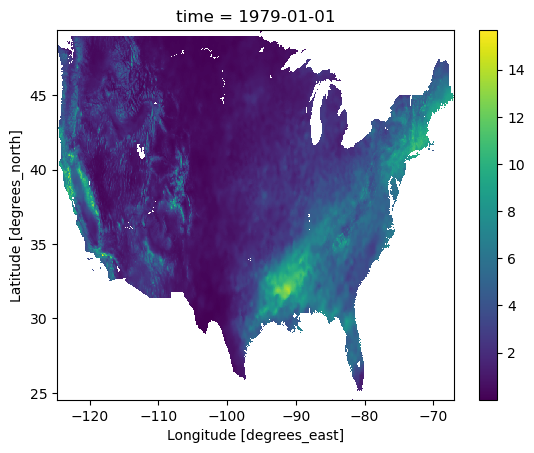

In [6]:
# Generate the map of precipitation rate from nClimGrid monthly data
obs_rate[0].plot()

In this quick map, we can see the value range of the precipitation rate appears to be on par (reasonably) comparing to the GPCP motnhly precipitation CDR data (0-20 mm/day). This is the basis for our comparison - make sure the satellite data and observations are describing the same quantity.

## **Section 1.2: Read GPCP Monthly Precipitation Data**

In this comparison, let's read in the monthly GPCP data again from AWS public data catalog.

In [7]:
# Get the list of all data files in the AWS S3 bucket
fs = s3fs.S3FileSystem(anon=True)
file_pattern = 'noaa-cdr-precip-gpcp-monthly-pds/data/*/gpcp_v02r03_monthly_*.nc'
file_location = fs.glob(file_pattern)

# Open connection to all data files
file_ob = [pooch.retrieve('http://s3.amazonaws.com/'+file,known_hash=None ) for file in file_location]

# Open all the monthly data files and concatenate them along the time dimension.
# This process will take ~ 1 minute to complete due to the number of data files.
ds_gpcp = xr.open_mfdataset(file_ob, combine='nested', concat_dim='time')
ds_gpcp


<xarray.Dataset>
Dimensions:       (latitude: 72, longitude: 144, time: 530, nv: 2)
Coordinates:
  * latitude      (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude     (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time          (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-02-01
Dimensions without coordinates: nv
Data variables:
    lat_bounds    (time, latitude, nv) float32 dask.array<chunksize=(1, 72, 2), meta=np.ndarray>
    lon_bounds    (time, longitude, nv) float32 dask.array<chunksize=(1, 144, 2), meta=np.ndarray>
    time_bounds   (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    precip        (time, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
    precip_error  (time, latitude, longitude) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
Attributes: (12/45)
    Conventions:                CF-1.6, ACDD 1.3
    title:                      Global Precipitation Climatatology Project (G...
    source:                     oc.197901.sg
    references:                 Huffman et al. 1997, http://dx.doi.org/10.117...
    history:                    1) �R
`�, Dr. Jian-Jian Wang, U of Maryland,...
    Metadata_Conventions:       CF-1.6, Unidata Dataset Discovery v1.0, NOAA ...
    ...                         ...
    metadata_link:              gov.noaa.ncdc:C00979
    product_version:            v23rB1
    platform:                   NOAA POES (Polar Orbiting Environmental Satel...
    sensor:                     AVHRR>Advanced Very High Resolution Radiometer
    spatial_resolution:         2.5 degree
    comment:                    Processing computer: eagle2.umd.edu

In [9]:
# Get the GPCP precipitation rate
prcp_sat = ds_gpcp.precip
prcp_sat

<xarray.DataArray 'precip' (time: 530, latitude: 72, longitude: 144)>
dask.array<concatenate, shape=(530, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-02-01
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of GPCP Monthly Satellite-...
    standard_name:  precipitation amount
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

## **Section 1.3: Spatial Pattern**

Now, let's take a quick look at the spatial pattern between these two datasets for a selected month (e.g., 1979-01-01).

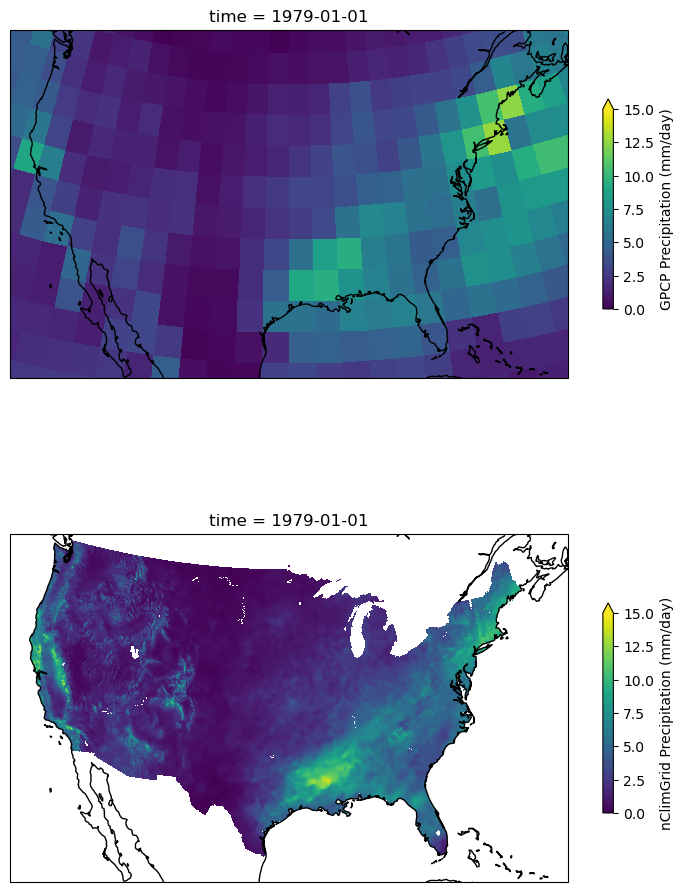

In [10]:
# Set up the geographical region for continental US
central_lat = 37.5
central_lon = -96
extent = [-120, -70, 21, 50]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# Extract sat and obs data for the month of 1979-01-01
sat = prcp_sat.sel(time='1979-01-01')
obs = obs_rate.sel(time='1979-01-01')

# Initate plot for North America using two suplots
fig,axs = plt.subplots(2, subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                       figsize=(9,12), sharex=True, sharey=True)
axs[0].set_extent(extent)
axs[0].coastlines()
axs[0].set_title('GPCP Monthly')
sat.plot(ax=axs[0], transform=ccrs.PlateCarree(),
         vmin = 0, vmax = 15,
         cbar_kwargs=dict(shrink=0.5, label='GPCP Precipitation (mm/day)'))
axs[1].set_extent(extent)
axs[1].coastlines()
axs[1].set_title('nClimGrid Monthly')
obs.plot(ax=axs[1], transform=ccrs.PlateCarree(),
         vmin = 0, vmax = 15,
         cbar_kwargs=dict(shrink=0.5, label='nClimGrid Precipitation (mm/day)'))

Overall, we have a similar spatial pattern but with widely different spatial resolution (e.g., 5km v.s. 2.5°). 

## **Section 1.4: Time series comparison**

Let's use New York City as an example, we can examine the time series of the satellite and observation-based dataset to evaluate the performance.

The latitute and longitute of NYC is `(40.71°N, 74.01°W)`. We will use it to extract the time series from GPCP and nClimGrid.

#### ohad comment: I don't even understand why bother plotting the first graph. the units of the variables are not the same. 
#### plus, it was mentioned in the relevant tutorial before. I'll delete this. graph 

In [11]:
# Note that GPCP data is stored as 0-360 degree for the longitude, so the longitude should be using (360 - lon)
sat = prcp_sat.sel(longitude=285.99, latitude=40.71, method='nearest')
obs = obs_rate.sel(lon=-74.01, lat=40.71, method='nearest') #precipitation rate
obs_total = prcp_obs.sel(lon=-74.01, lat=40.71, method='nearest') #total amount

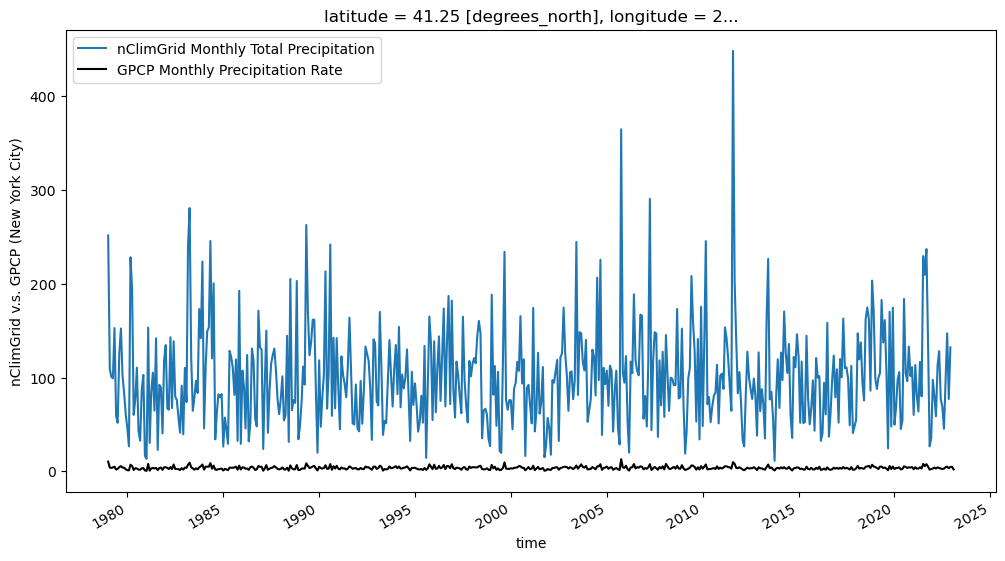

In [12]:
# Let's first look at the comparison between the total amount from nClimGrid
fig = plt.figure(figsize=(12,6))
obs_total.prcp.plot(label='nClimGrid Monthly Total Precipitation')
sat.plot(color='k', label='GPCP Monthly Precipitation Rate')
plt.ylabel('nClimGrid v.s. GPCP (New York City)')
plt.legend()

We clearly see the systematic shift between the total precipitation amount from nClimGrid data and the precipitation rate from GPCP. Now, let's see if the nClimGrid rate will be any better for the evaluation.

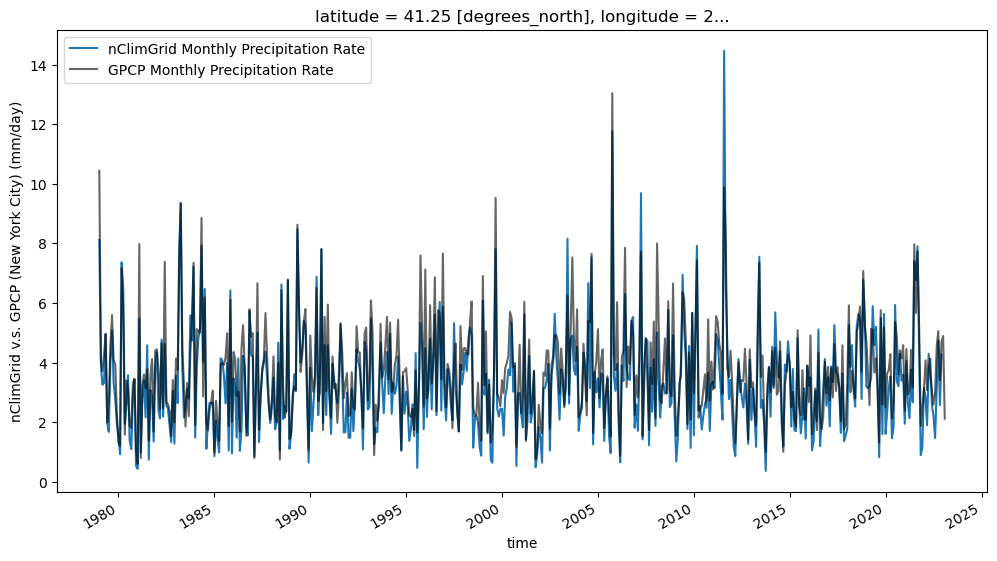

In [13]:
# Let's look at the comparison between the precipitation rate from nClimGrid
fig = plt.figure(figsize=(12,6))
obs.plot(label='nClimGrid Monthly Precipitation Rate')
sat.plot(color='k', alpha=0.6, label='GPCP Monthly Precipitation Rate')
plt.ylabel('nClimGrid v.s. GPCP (New York City) (mm/day)')
plt.legend()

The plot show much improvement between the two datasets because now we are looking at the same quantity of the precipitation rate. We are going to zoom in to a few years to see how the data compares.

#### ohad comment: again, the plot doesn't show an imporvement. if you plot rain vs rate you won't get anything. 

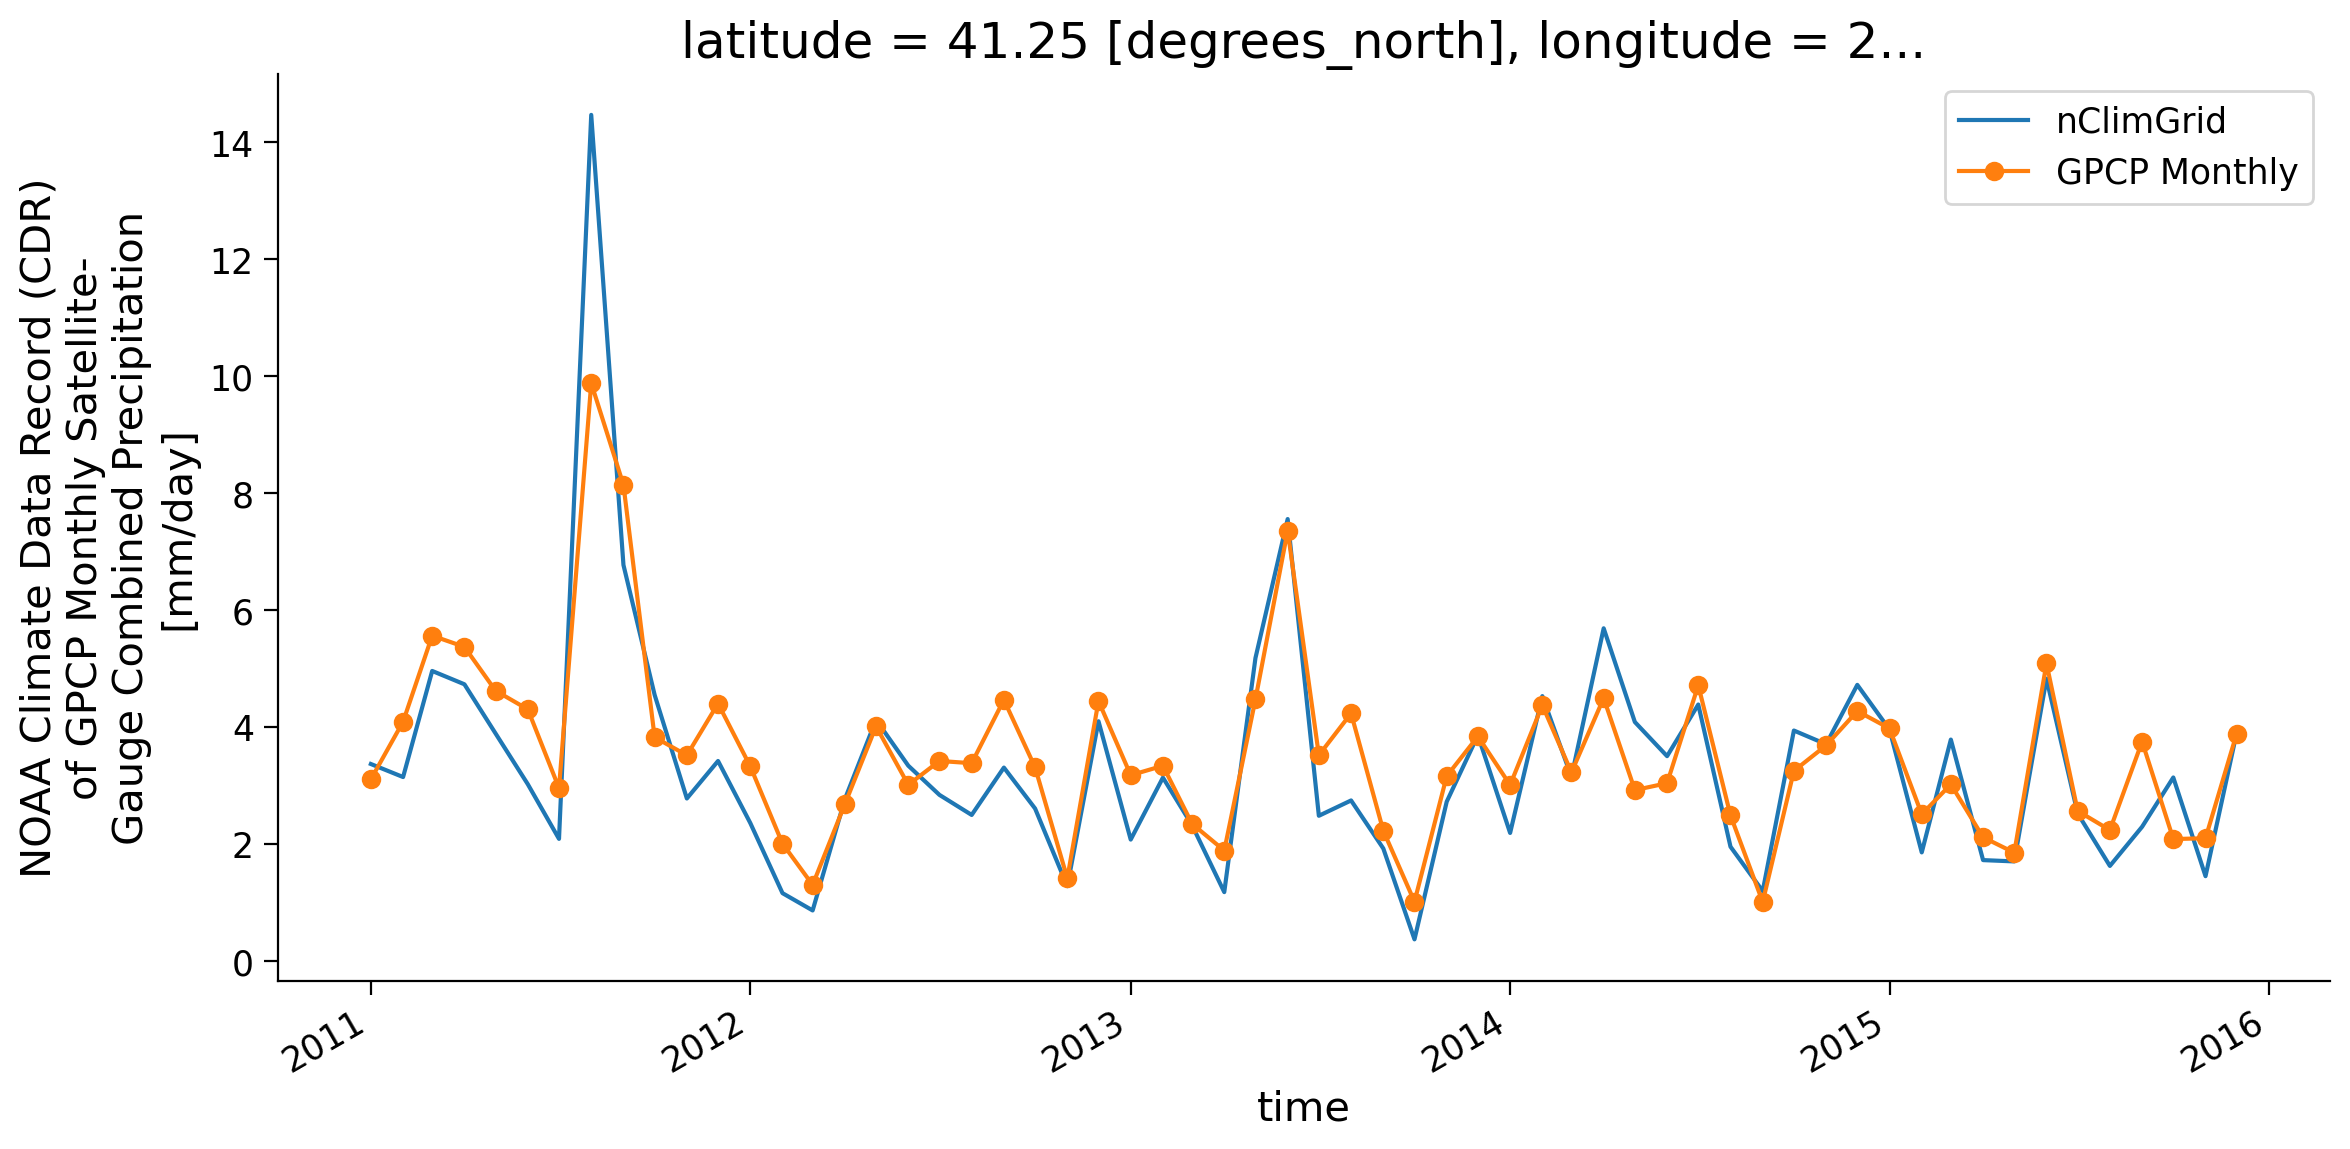

In [19]:
fig = plt.figure(figsize=(12, 6))
obs.sel(time=slice('2011-01-01', '2015-12-01')).plot(label='nClimGrid')
sat.sel(time=slice('2011-01-01', '2015-12-01')).plot(marker='o', label='GPCP Monthly')
plt.legend()

We see a great alignment in the precipitation rate between the nClimGrid and GPCP data when we look at the details in a small time window.

## **Section 1.5: Quantify the Difference**

We are not looking at the quantitative evaluation of the satellite data with observations. In the scatter plot, we would love to see it go along the 1:1 line in the plot since ideally we want the values to be exactly the same.

In [20]:
# Make sure that both observation and satellite data are for the samte time period
sat = sat.sel(time=slice('1979-01-01','2022-12-01'))
obs = obs.sel(time=slice('1979-01-01','2022-12-01'))

C:\Users\ohadz\AppData\Local\Temp\ipykernel_14408\3760470833.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot((0,15), (0,15), 'k-', color = 'r')


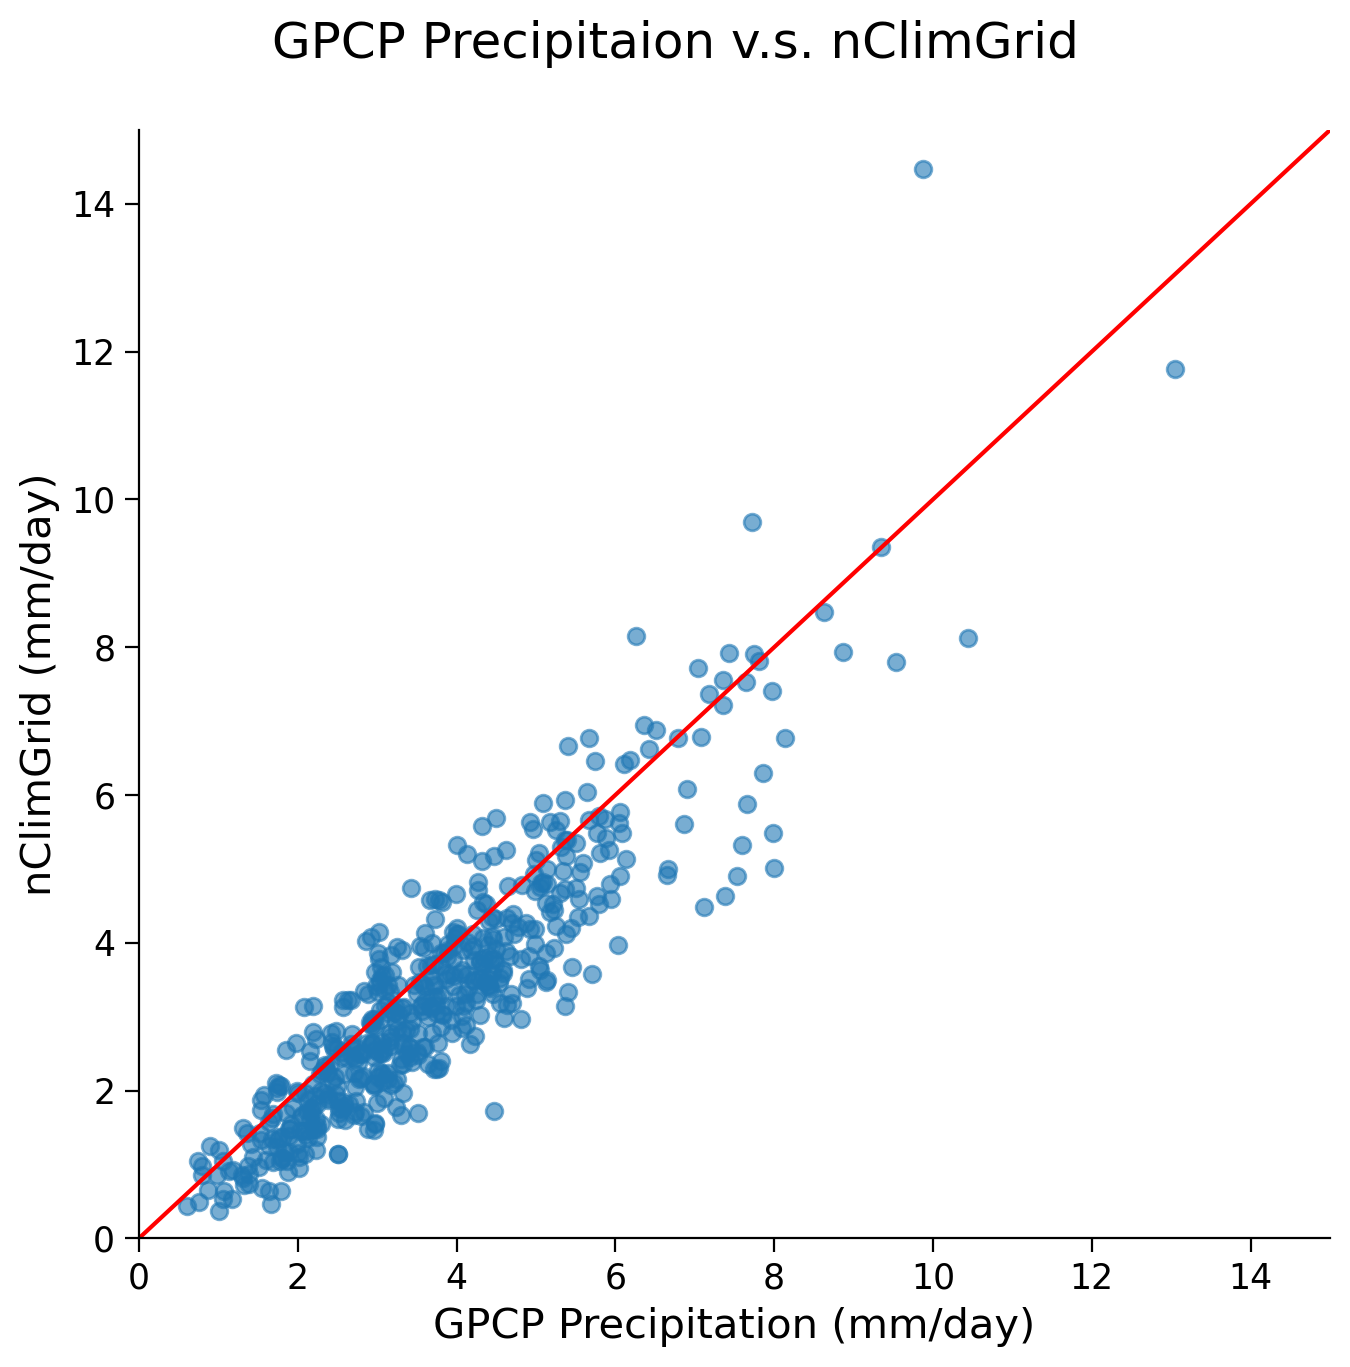

In [21]:
# Plot the scatter plot between nClimGrid and GPCP monthly precipitation CDR
fig = plt.figure(figsize=(7,7))
fig.suptitle('GPCP Precipitaion v.s. nClimGrid')
plt.scatter(sat, obs, alpha=0.6)
# Add 1:1 line
y_lim = (0,15)
x_lim = (0,15)
plt.plot((0,15), (0,15), 'k-', color = 'r')
plt.ylim(y_lim)
plt.xlim(x_lim)
plt.xlabel('GPCP Precipitation (mm/day)')
plt.ylabel('nClimGrid (mm/day)')
plt.show()

We see a strong correlation between the satellite data and the observations for NYC. We now can also calculate the correlation between these two time series.

### **Exercise: Compare the anomaly**

For climate applications, sometimes we are more interested in the difference among the anomaly data to study the trend. So can you compare the anomaly for the time series of the NYC? 

In [22]:
################################################################################
# Exercise: Compare the anomaly of precipitation rate for NYC.                 #
################################################################################

# Step 1: Extract time series of NYC for both GPCP and nClimGrid precipitation rate

# Step 2: Calculate climatology for the 1981-2010 period for both GPCP and
#         nClimGrid

# Step 3: Calculate anomaly of the NYC time series for both GPCP and nClimGrid

# Step 4: Plot time series and scatter plot between two time series

# Step 5: Calculate correlation coefficient & mean differences


# ohad comment: I've changed the questions. steps 1 is  already done above. only steps needed are 2-5
'''

Please describe the relationship between the anomaly time series between two data:

'''

'\n\nPlease describe the relationship between the anomaly time series between two data:\n\n'

C:\ProgramData\Anaconda3\envs\climatematch_test\lib\site-packages\xarray\core\indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 42 times more chunks
  return self.array[key]
C:\Users\ohadz\AppData\Local\Temp\ipykernel_19020\632670849.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot((0,15), (0,15), 'k-', color = 'r')


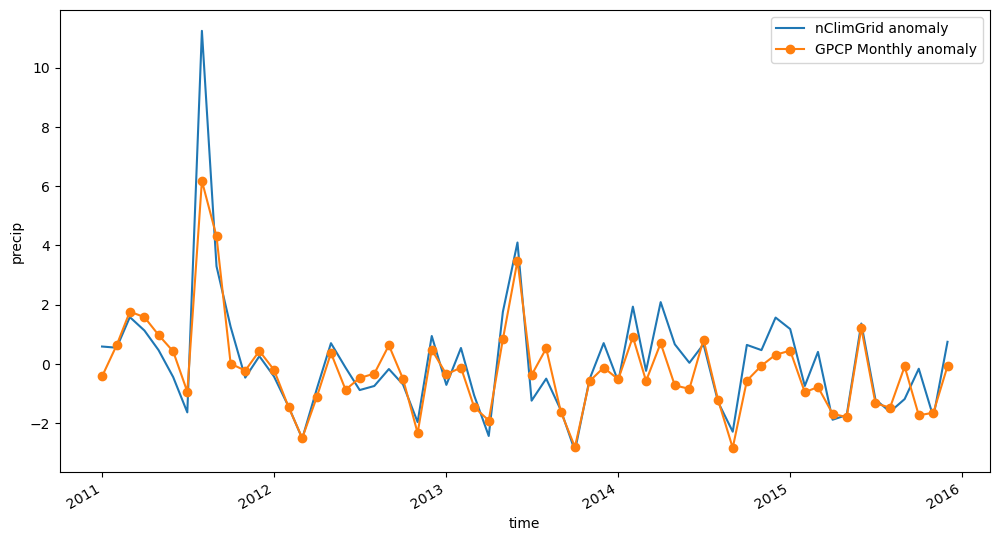

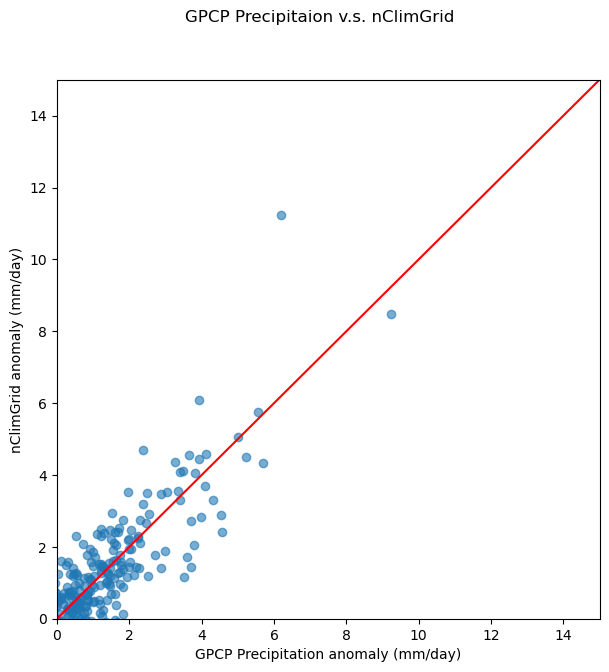

 correlation of the difference between sat and obs : 0.9094389307738011 with a p-value of: 1.959270177311404e-193


In [22]:
# to remove solution

################################################################################
# Exercise: Compare the anomaly of precipitation rate for NYC.                 #
################################################################################

# Step 1: Calculate climatology for the 1981-2010 period for both GPCP and
#         nClimGrid
sat_clim=sat.sel(time=slice('1981-01-01', '2010-12-01')).groupby('time.month').mean(dim='time')
obs_clim=obs.sel(time=slice('1981-01-01', '2010-12-01')).groupby('time.month').mean(dim='time')

# Step 2: Calculate anomaly of the NYC time series for both GPCP and nClimGrid
sat_clim_anom = sat.sel(time=slice('1981-01-01', '2022-12-01')).groupby('time.month') - sat_clim
obs_clim_anom = obs.sel(time=slice('1981-01-01', '2022-12-01')).groupby('time.month') - obs_clim

# Step 3: Plot time series and scatter plot between two time series

fig = plt.figure(figsize=(12, 6))
obs_clim_anom.sel(time=slice('2011-01-01', '2015-12-01')).plot(label='nClimGrid anomaly')
sat_clim_anom.sel(time=slice('2011-01-01', '2015-12-01')).plot(marker='o', label='GPCP Monthly anomaly')
plt.legend()

# Plot the scatter plot between nClimGrid and GPCP monthly precipitation CDR
fig = plt.figure(figsize=(7,7))
fig.suptitle('GPCP Precipitaion v.s. nClimGrid')
plt.scatter(sat_clim_anom, obs_clim_anom, alpha=0.6)
# Add 1:1 line
y_lim = (0,15)
x_lim = (0,15)
plt.plot((0,15), (0,15), 'k-', color = 'r')
plt.ylim(y_lim)
plt.xlim(x_lim)
plt.xlabel('GPCP Precipitation anomaly (mm/day)')
plt.ylabel('nClimGrid anomaly (mm/day)')
plt.show()

# Step 4: Calculate correlation coefficient & mean differences
from scipy import stats

r,p = stats.pearsonr(sat_clim_anom, obs_clim_anom) 
print (' correlation of the difference between sat and obs : '+str(r)+' with a p-value of: '+str(p))


# **Summary**

In this tutorial, we have explored how to use station-based observations within the U.S. to evaluate satellite precipitation data. While this isn't a global comparison, the methodology can be applied to other station or observation data you may wish to utilize.

When carrying out these comparisons, remember the following key points:

- Ensure that both the satellite data and the observations are representing the same quantity (for example, total precipitation amount versus precipitation rate).
- Comparisons should be made for the same geolocation (or very near to it) and the same time period.
- Be aware of potential spatial scale effects. Satellite data measures over a large area, whereas observations may be narrowly focused, particularly for elements that exhibit substantial spatial variability. This can lead to considerable uncertainty in the satellite data.
